In [1]:
import warnings 
from collections import OrderedDict

import numpy as np
import pandas as pd
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, recall_score, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder,\
                                  MinMaxScaler, Normalizer, FunctionTransformer
from sklearn.svm import SVC

from src.utils import cleaning, eda, config, sktools, metrics
from src.utils.classes import LogisticRegressionWithThreshold

# Options
warnings.simplefilter('ignore')

### Simple Data Cleaning

In [2]:
# Load the original dataset
df = cleaning.load_data(config.ORIG_DATA_PATH)
df.head()

,Customer Number,Offer Accepted,Reward,Mailer Type,Income Level,# Bank Accounts Open,Overdraft Protection,Credit Rating,# Credit Cards Held,# Homes Owned,Household Size,Own Your Home,Average Balance,Q1 Balance,Q2 Balance,Q3 Balance,Q4 Balance
0,1,No,Air Miles,Letter,High,1,No,High,2,1,4,No,1160.75,1669.0,877.0,1095.0,1002.0
1,2,No,Air Miles,Letter,Medium,1,No,Medium,2,2,5,Yes,147.25,39.0,106.0,78.0,366.0
2,3,No,Air Miles,Postcard,High,2,No,Medium,2,1,2,Yes,276.50,367.0,352.0,145.0,242.0
3,4,No,Air Miles,Letter,Medium,2,No,High,1,1,4,No,1219.00,1578.0,1760.0,1119.0,419.0
4,5,No,Air Miles,Letter,Medium,1,No,Medium,2,1,6,Yes,1211.00,2140.0,1357.0,982.0,365.0


In [3]:
# Data cleaning
df = cleaning.drop_nan(df, verbose=True)

Dropped 24 rows, 0.13% of original rows


In [4]:
# Formatting index and column names
df = cleaning.format_data(df)
df.head()

,offer_accepted,reward,mailer_type,income_level,bank_accounts_open,overdraft_protection,credit_rating,credit_cards_held,homes_owned,household_size,own_your_home,average_balance,q1_balance,q2_balance,q3_balance,q4_balance
customer_number,,,,,,,,,,,,,,,,
1,No,Air Miles,Letter,High,1,No,High,2,1,4,No,1160.75,1669.0,877.0,1095.0,1002.0
2,No,Air Miles,Letter,Medium,1,No,Medium,2,2,5,Yes,147.25,39.0,106.0,78.0,366.0
3,No,Air Miles,Postcard,High,2,No,Medium,2,1,2,Yes,276.50,367.0,352.0,145.0,242.0
4,No,Air Miles,Letter,Medium,2,No,High,1,1,4,No,1219.00,1578.0,1760.0,1119.0,419.0
5,No,Air Miles,Letter,Medium,1,No,Medium,2,1,6,Yes,1211.00,2140.0,1357.0,982.0,365.0


In [6]:
# Value counts file dump
cleaning.dump_value_counts(config.VALUE_COUNTS_PATH, df, verbose=True)

FileNotFoundError: [Errno 2] No such file or directory: 'src/data/tmp/value_counts.txt/value_counts-1656311796.0140607.txt'

In [7]:
# Save cleaned data
df.to_csv(config.CLEANED_DATA_PATH)

### EDA

In [8]:
# Load cleaned dataset
df = cleaning.load_data(config.CLEANED_DATA_PATH, index_col=0)
eda.report(df)

,nan_count,dtype,unique
offer_accepted,0,object,2
reward,0,object,3
mailer_type,0,object,2
income_level,0,object,3
bank_accounts_open,0,int64,3
overdraft_protection,0,object,2
credit_rating,0,object,3
credit_cards_held,0,int64,4
homes_owned,0,int64,3
household_size,0,int64,8


In [9]:
# Statistics of numerical features of the dataset
df.describe()

,bank_accounts_open,credit_cards_held,homes_owned,household_size,average_balance,q1_balance,q2_balance,q3_balance,q4_balance
count,17976.000000,17976.000000,17976.000000,17976.000000,17976.000000,17976.000000,17976.000000,17976.000000,17976.000000
mean,1.255730,1.903427,1.203549,3.499110,940.515562,910.450656,999.392190,1042.033600,810.185803
std,0.472405,0.797086,0.427446,1.114476,350.297837,620.077060,457.402268,553.452599,559.001365
min,1.000000,1.000000,1.000000,1.000000,48.250000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,1.000000,3.000000,787.500000,392.750000,663.000000,633.000000,363.000000
50%,1.000000,2.000000,1.000000,3.000000,1007.000000,772.000000,1032.000000,945.500000,703.000000
75%,1.000000,2.000000,1.000000,4.000000,1153.250000,1521.000000,1342.000000,1463.000000,1212.000000
max,3.000000,4.000000,3.000000,9.000000,3366.250000,3450.000000,3421.000000,3823.000000,4215.000000


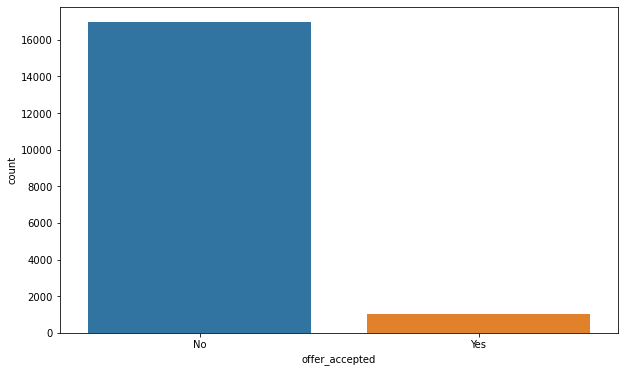

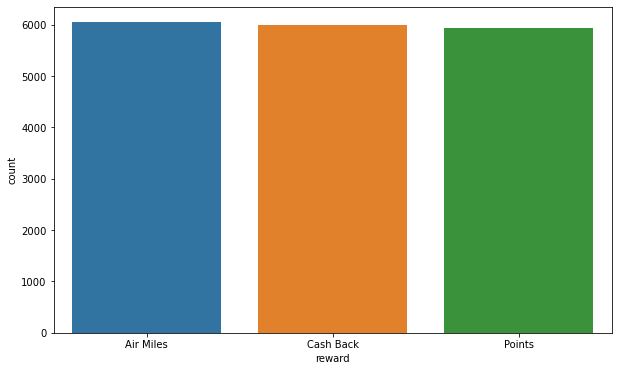

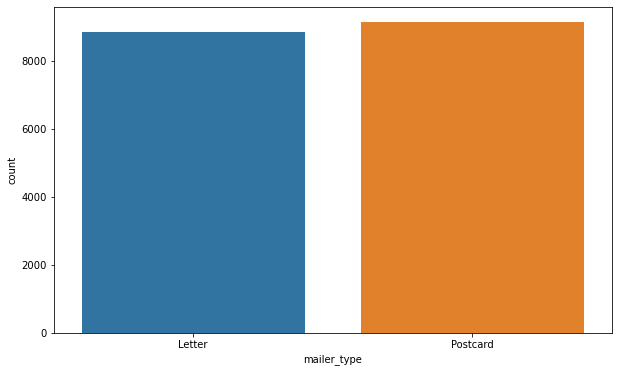

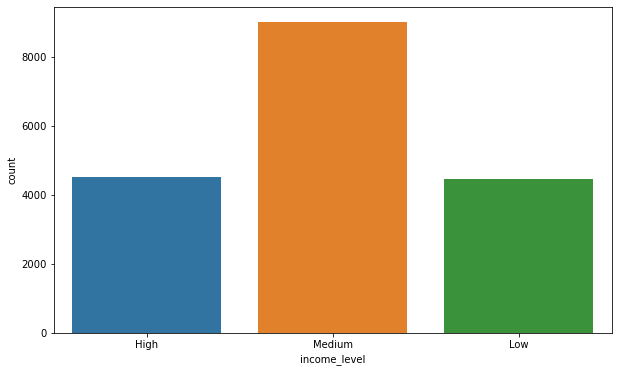

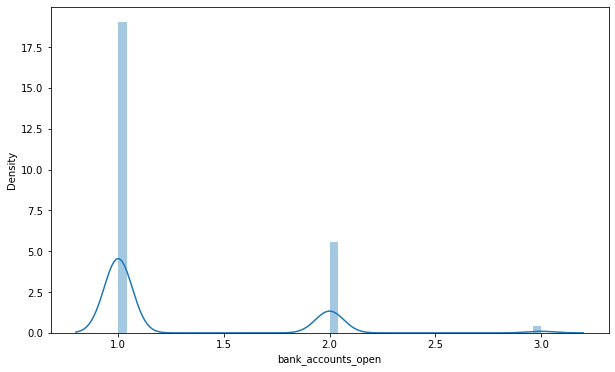

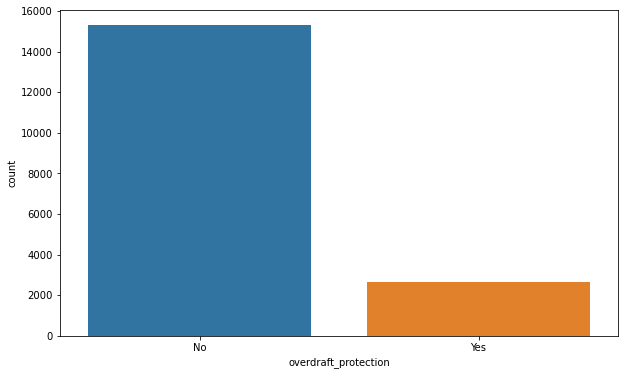

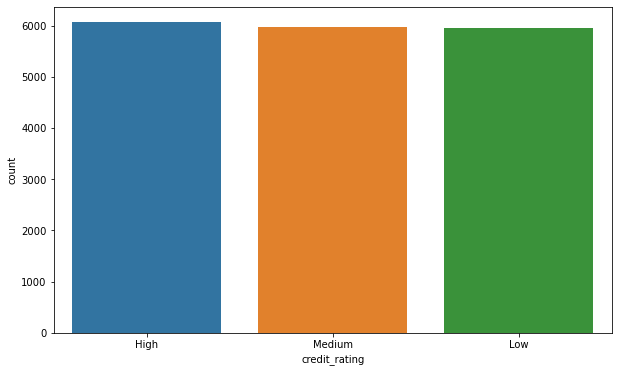

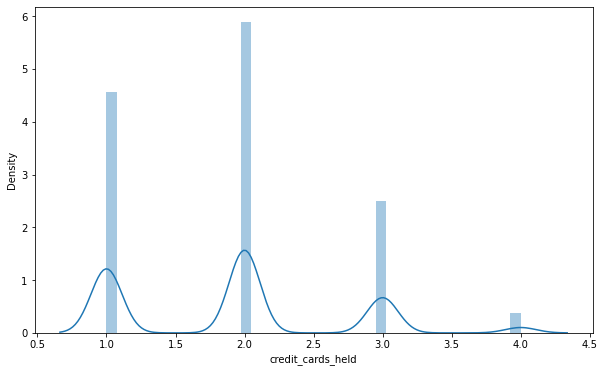

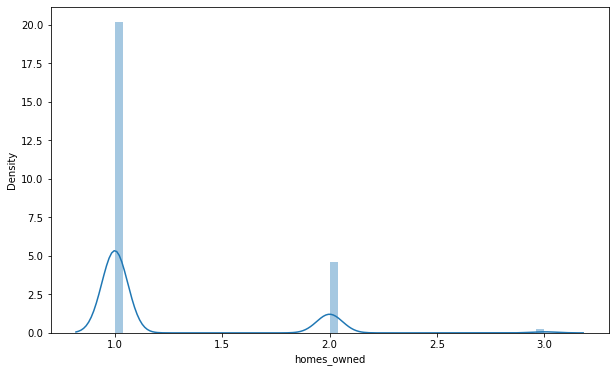

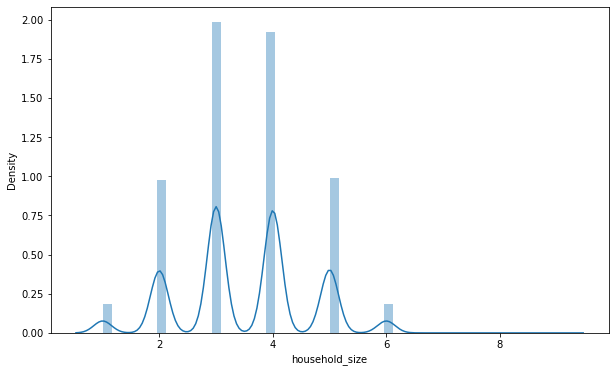

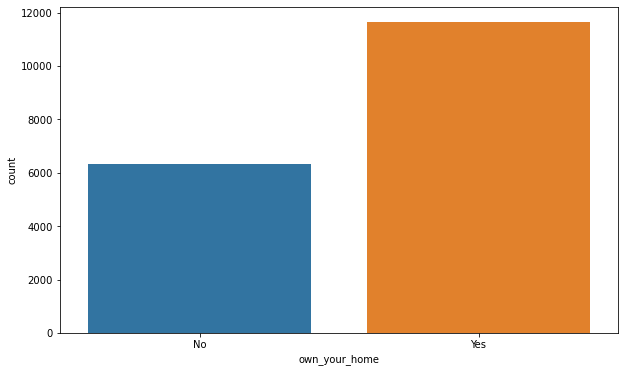

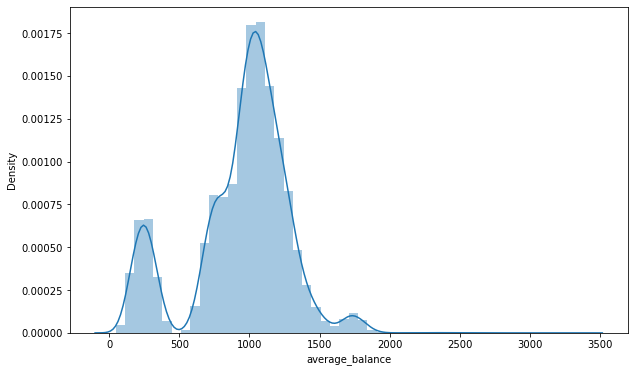

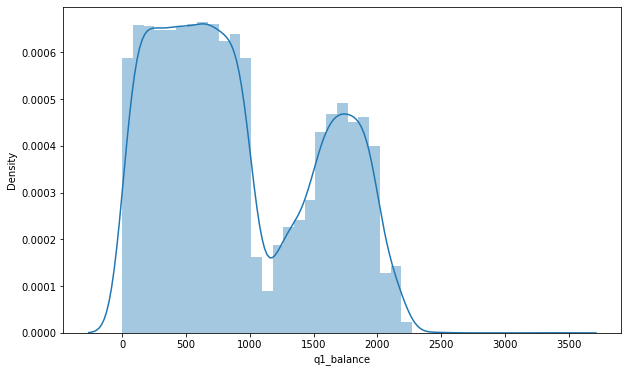

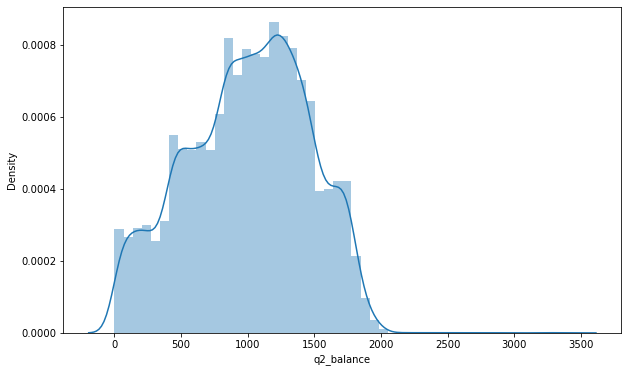

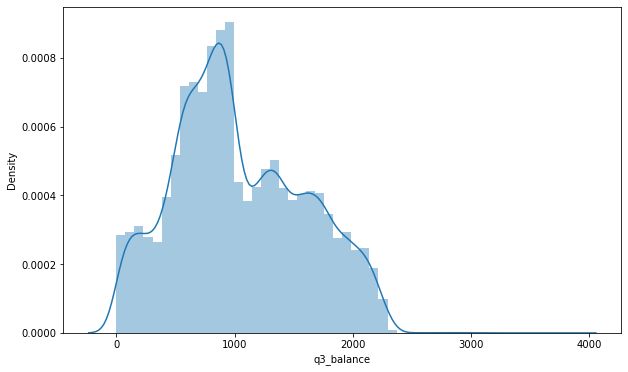

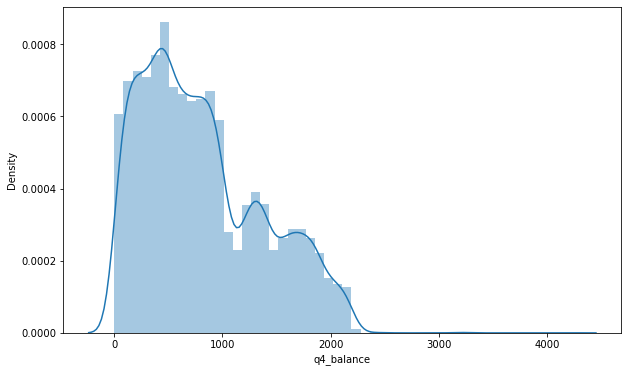

In [ ]:
# Take a look at some distributions
eda.plot_distributions(df, (10, 6))

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

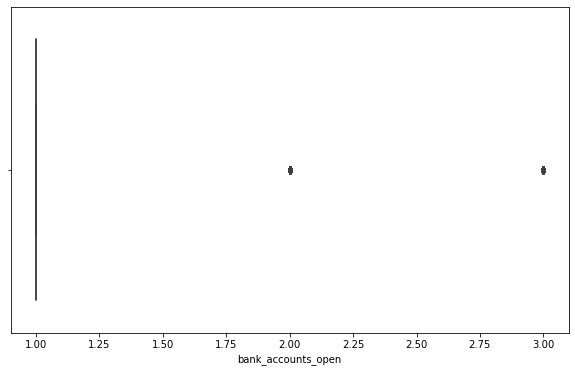

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

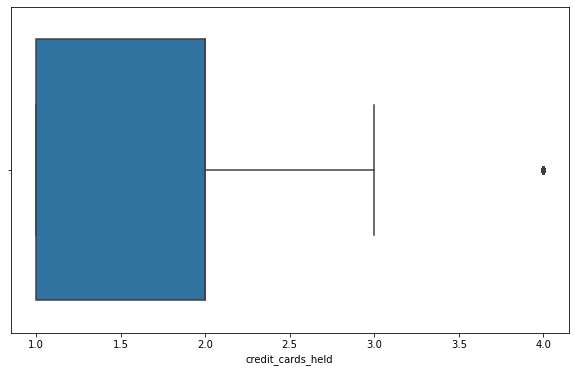

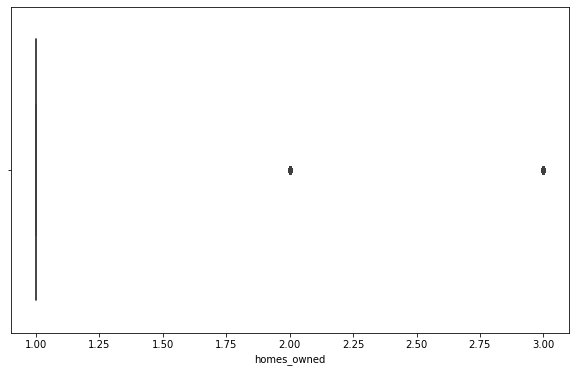

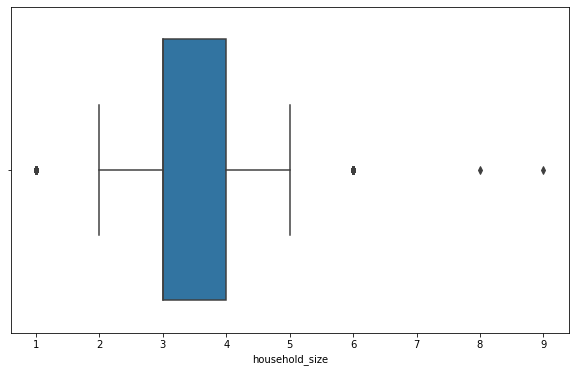

<Figure size 720x432 with 0 Axes>

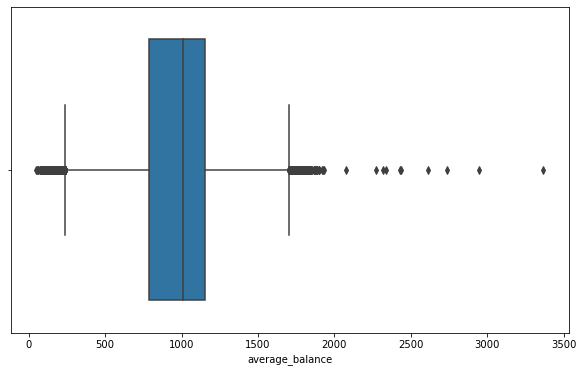

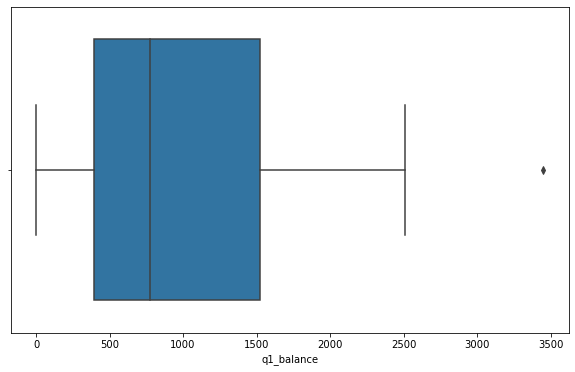

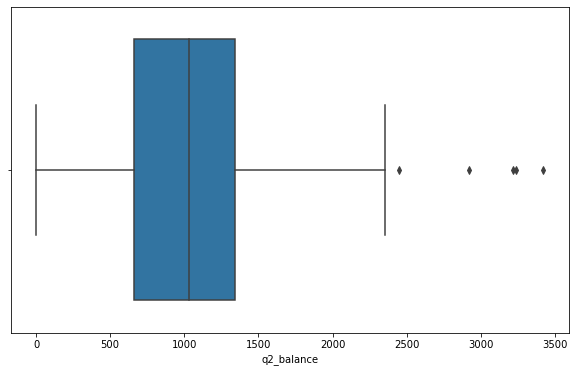

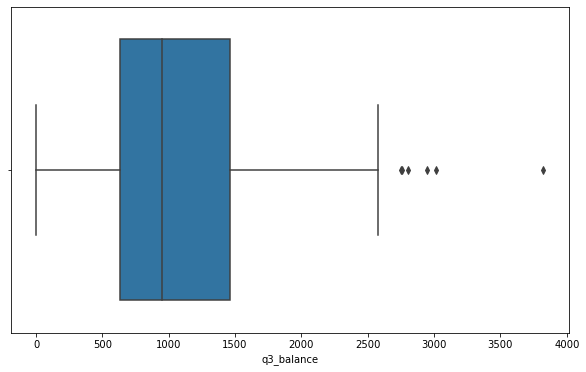

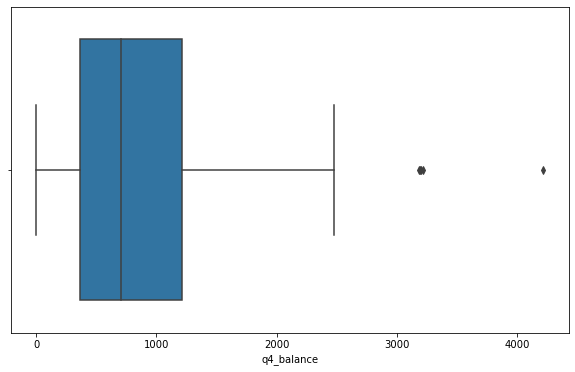

In [ ]:
# Take a look to the outliers
eda.plot_outliers(df, (10, 6))

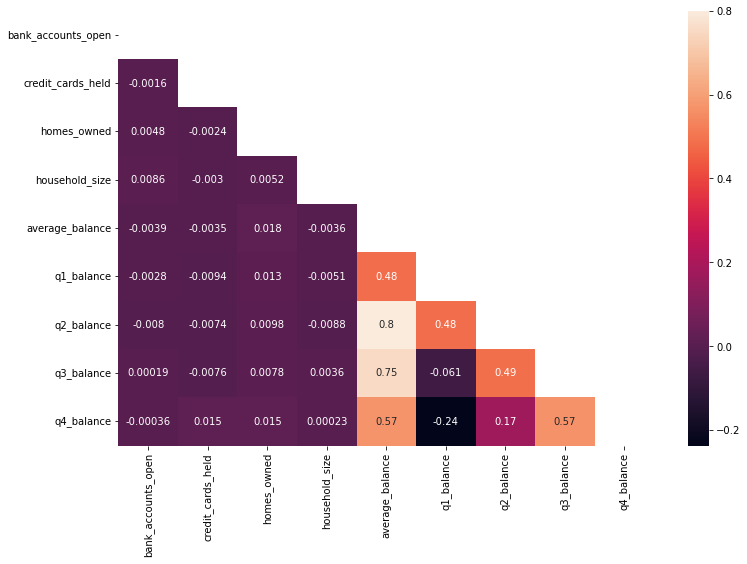

In [11]:
# Take a look to correlation heatmap
eda.show_corr_heatmap(df, figsize=(12, 8))

In [13]:
# Following couples present multicollinearity
eda.report_multicoll(df)

,feat1,feat2,corr
0,average_balance,q3_balance,0.752741
1,average_balance,q4_balance,0.572380
2,average_balance,q2_balance,0.800285
3,average_balance,q1_balance,0.481507
4,q1_balance,q2_balance,0.483134
5,q2_balance,q3_balance,0.487710
6,q3_balance,q4_balance,0.565298


### Benchmark Models
In following section the Benchmark models are presented in order to get an <br>
initial idea on how the different classifiers perform with a raw dataset with <br>
minimal tuning to the model. The classifier analized are:
- Logistic Regression
- Naive Bayes (Multinomial)
- Naive Bayes (Gaussian)
- K-Neares Neighbors
- Support Vector Machine (SVC)
- Decision Tree (Random Forest Classifier)

Models are implemented all with the same modifications on the dataset:
- MinMax Scaler applied to numerical data;
- One Hot Encoder applied to categorical data;
- No feature engineer or reduction;
- No consideration of multicollinearity between features;
- Dataset is balanced, otherwise all models fail due to high imbalance;
- No outliers dropped;
- No parameters tuning on the models.

In [16]:
# Benchmark models parameters
cols_onehot_encod = ['reward', 'mailer_type', 'overdraft_protection', 
                     'own_your_home', 'income_level', 'credit_rating'] 
target = config.TARGET
models_bench = [LogisticRegression(), MultinomialNB(), GaussianNB(), KNeighborsClassifier(), 
          SVC(), RandomForestClassifier()]
scaler_bench = MinMaxScaler()
encoder_bench = OneHotEncoder()

In [17]:
# Benchmark models performances
y_true_bench, y_pred_bench = [], []
for model in models_bench:
    print('Model: ', str(model).strip('()')) 
    y_test, predictions, report = sktools.score_classification_model(
                                df=df,
                                target=target,
                                model=model,
                                cols_to_encode=[cols_onehot_encod],
                                scaler=scaler_bench,
                                encoders=[encoder_bench],
                                balance_dataset=True,
                                balancer=SMOTE()
    )
    y_true_bench.append(y_test)
    y_pred_bench.append(predictions)
    print(report, end='\n\n')

Model:  LogisticRegression
              precision    recall  f1-score   support

          No       0.98      0.67      0.79      4241
         Yes       0.12      0.72      0.20       253

    accuracy                           0.67      4494
   macro avg       0.55      0.70      0.50      4494
weighted avg       0.93      0.67      0.76      4494


Model:  MultinomialNB
              precision    recall  f1-score   support

          No       0.98      0.66      0.79      4241
         Yes       0.11      0.74      0.20       253

    accuracy                           0.67      4494
   macro avg       0.55      0.70      0.49      4494
weighted avg       0.93      0.67      0.76      4494


Model:  GaussianNB
              precision    recall  f1-score   support

          No       0.97      0.70      0.81      4241
         Yes       0.11      0.65      0.19       253

    accuracy                           0.70      4494
   macro avg       0.54      0.67      0.50      4494
weig

How can we measure our models performance?<br>
We are interested obviously to have an high recall on the 'Yes' class, meaning <br>
that we want to be sure to target all possible customers that will accept the <br>
card offer. <br>
However, during the following paragraphs it is possible to see that with the <br>
'high' recall comes a low 'precision' on the 'Yes' class. <br>
Let's take a look to recall scores for these benchmark models below:

,model,recall_score
0,MultinomialNB(),0.735178
1,LogisticRegression(),0.72332
2,GaussianNB(),0.648221
3,SVC(),0.561265
4,KNeighborsClassifier(),0.288538
5,"(DecisionTreeClassifier(max_features='auto', r...",0.047431


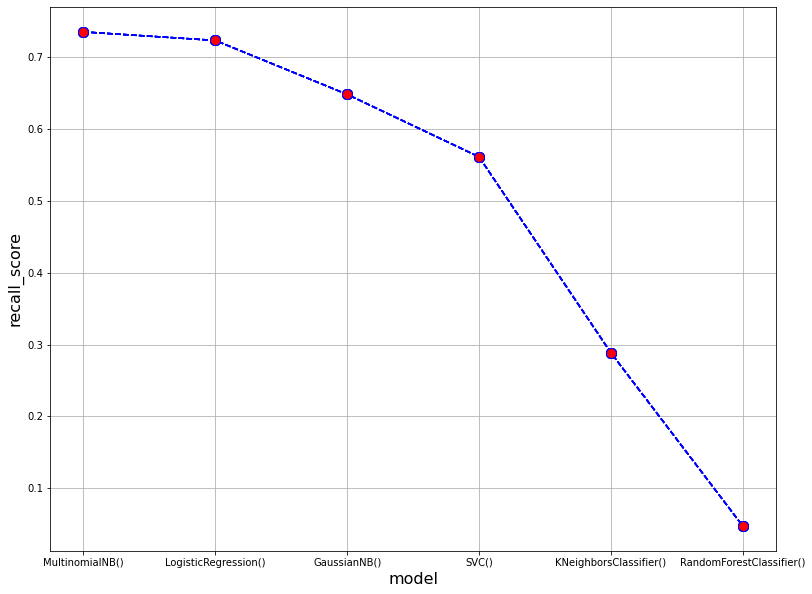

In [18]:
params_bench = dict(model=models_bench)
metrics.report_metrics(params=params_bench,
                       metric=recall_score,
                       label='Yes',
                       all_true=y_true_bench,
                       all_pred=y_pred_bench,
                       sort_by_metric=True,
                       show_plot=True,
                       figsize=(13, 10),
                       )

### Models optimization
1. Scaling methods
2. Encoding methods
3. Outliers handling
4. Multicollinearity 
5. Balancing methods
6. ML model tuning

Logistic Regression and Naive Bayes (Multinomial) models seem to have the best <br> 
performance on the classification. <br>
Logistic Regression and Naive Bayes (Multinomial) will now be optimized and lastly <br>
a Grid Optimization will be performed on the SVC, Logistic Regression (and maybe Random forests) <br>


#### 1. Scaling Methods

In [19]:
# Parameters definition
scalers = [StandardScaler(), MinMaxScaler(), Normalizer(),
            FunctionTransformer(np.log)]
models = [LogisticRegression(), MultinomialNB()]
all_test, all_pred, all_reports = [], [], []

# Score models with different scalers and save the results
for model in models:
    for scaler in scalers:
        print('Model: ', str(model).strip('()')) 
        print('Scaler: ', str(scaler).strip('()'))
        try:
            y_test, predictions, report = sktools.score_classification_model(
                                    df=df,
                                    target=target,
                                    model=model,
                                    cols_to_encode=[cols_onehot_encod],
                                    scaler=scaler,
                                    encoders=[OneHotEncoder()],
                                    balance_dataset=True,
                                    balancer=SMOTE(),
            )
            print(report, end='\n\n')
            all_test.append(y_test)
            all_pred.append(predictions)
            all_reports.append(report)
        except:
            print('****FAILED****', end='\n\n')
            all_test.append(np.nan)
            all_pred.append(np.nan)
            all_reports.append(np.nan)

Model:  LogisticRegression
Scaler:  StandardScaler
              precision    recall  f1-score   support

          No       0.97      0.69      0.81      4241
         Yes       0.12      0.70      0.20       253

    accuracy                           0.69      4494
   macro avg       0.55      0.70      0.50      4494
weighted avg       0.93      0.69      0.77      4494


Model:  LogisticRegression
Scaler:  MinMaxScaler
              precision    recall  f1-score   support

          No       0.98      0.67      0.79      4241
         Yes       0.12      0.73      0.20       253

    accuracy                           0.67      4494
   macro avg       0.55      0.70      0.50      4494
weighted avg       0.93      0.67      0.76      4494


Model:  LogisticRegression
Scaler:  Normalizer
              precision    recall  f1-score   support

          No       0.98      0.67      0.79      4241
         Yes       0.12      0.75      0.21       253

    accuracy                     

,models,scalers,recall_score
0,LogisticRegression(),Normalizer(),0.750988
1,MultinomialNB(),MinMaxScaler(),0.743083
2,MultinomialNB(),Normalizer(),0.743083
3,LogisticRegression(),MinMaxScaler(),0.727273
4,LogisticRegression(),FunctionTransformer(func=<ufunc 'log'>),0.727273
5,MultinomialNB(),FunctionTransformer(func=<ufunc 'log'>),0.719368
6,LogisticRegression(),StandardScaler(),0.703557
7,MultinomialNB(),StandardScaler(),NaN


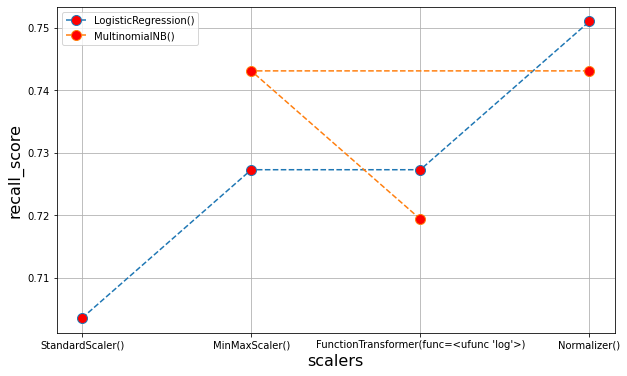

In [20]:
# metrics report and plot for different scalers
params = OrderedDict(
    models = [LogisticRegression(), MultinomialNB()],
    scalers = [StandardScaler(), MinMaxScaler(), Normalizer(),
            FunctionTransformer(np.log)]
)
metrics.report_metrics(params, recall_score, all_test, all_pred, label='Yes',
                        sort_by_metric=True, show_plot=True, hue='models')

Normalization is slightly better for both reference model. <br>

#### 2. Encoding Methods

In [21]:
encoders = [OrdinalEncoder(), OneHotEncoder()]
models = [LogisticRegression(), MultinomialNB()]
all_test, all_pred, all_reports = [], [], []

# Scaler influence on models performance
for model in models:
    for encoder in encoders:
        print('Model: ', str(model).strip('()')) 
        print('Encoder: ', str(encoder).strip('()'))
        try:
            y_test, predictions, report = sktools.score_classification_model(
                                    df=df,
                                    target=target,
                                    model=model,
                                    cols_to_encode=[cols_onehot_encod],
                                    scaler=Normalizer(),
                                    encoders=[encoder],
                                    balance_dataset=True,
                                    balancer=SMOTE()
            )
            print(report, end='\n\n')
            all_test.append(y_test)
            all_pred.append(predictions)
            all_reports.append(report)
        except:
            print('****FAILED****', end='\n\n')
            all_test.append(np.nan)
            all_pred.append(np.nan)
            all_reports.append(np.nan)

Model:  LogisticRegression
Encoder:  OrdinalEncoder
              precision    recall  f1-score   support

          No       0.96      0.59      0.74      4241
         Yes       0.09      0.63      0.15       253

    accuracy                           0.60      4494
   macro avg       0.52      0.61      0.44      4494
weighted avg       0.91      0.60      0.70      4494


Model:  LogisticRegression
Encoder:  OneHotEncoder
              precision    recall  f1-score   support

          No       0.98      0.67      0.80      4241
         Yes       0.12      0.74      0.21       253

    accuracy                           0.68      4494
   macro avg       0.55      0.71      0.50      4494
weighted avg       0.93      0.68      0.76      4494


Model:  MultinomialNB
Encoder:  OrdinalEncoder
              precision    recall  f1-score   support

          No       0.96      0.56      0.71      4241
         Yes       0.08      0.64      0.14       253

    accuracy                  

,models,encoders,recall_score
0,LogisticRegression(),OneHotEncoder(),0.743083
1,MultinomialNB(),OneHotEncoder(),0.731225
2,MultinomialNB(),OrdinalEncoder(),0.640316
3,LogisticRegression(),OrdinalEncoder(),0.632411


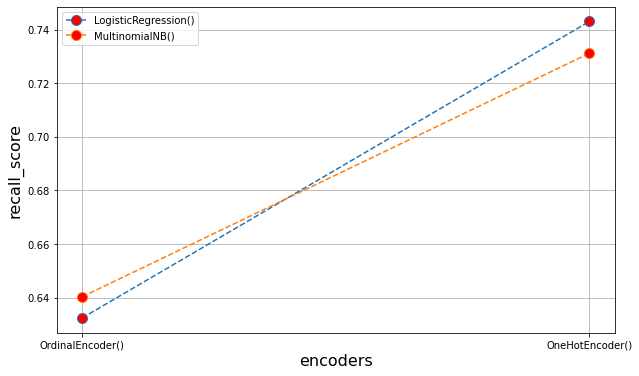

In [22]:
params = OrderedDict(
    models = [LogisticRegression(), MultinomialNB()],
    encoders = [OrdinalEncoder(), OneHotEncoder()]
)
metrics.report_metrics(params, recall_score, all_test, all_pred, label='Yes',
                        sort_by_metric=True, show_plot=True, hue='models')

The OneHotEncoder gives the best performances

#### 3. Multicollinearity

With multicollinearity accounted, I see strong relation with avg_balance and <br> all the q-balances. As a first measure I drop avg_balance and I keep only <br> q1 and q3 balances due to their low correlation factors (more distance <br> in time). 

In [23]:
# Features with multicoll
eda.report_multicoll(df)

,feat1,feat2,corr
0,average_balance,q3_balance,0.752741
1,average_balance,q4_balance,0.572380
2,average_balance,q2_balance,0.800285
3,average_balance,q1_balance,0.481507
4,q1_balance,q2_balance,0.483134
5,q2_balance,q3_balance,0.487710
6,q3_balance,q4_balance,0.565298


We can try to drop *average_balance* and we also note that multicollinearity <br>
is present in consecutive quarter balances.

In [24]:
cols_to_drop_1 = []
cols_to_drop_2 = ['average_balance', 'q1_balance', 'q3_balance']
cols_to_drop_3 = ['average_balance', 'q2_balance', 'q4_balance']
cols_to_drop_4 = ['average_balance']
multicoll_drop = [cols_to_drop_1, cols_to_drop_2, cols_to_drop_3, cols_to_drop_4]

In [25]:
models = [LogisticRegression(), MultinomialNB()]
all_test, all_pred, all_reports = [], [], []

# Scaler influence on models performance
for model in models:
    for cols_to_drop in multicoll_drop:
        print('Model: ', str(model).strip('()')) 
        print('Cols dropped --> ',cols_to_drop)
        df_multicoll = df.drop(cols_to_drop, axis=1)
        try:
            y_test, predictions, report = sktools.score_classification_model(
                                    df=df_multicoll,
                                    target=target,
                                    model=model,
                                    cols_to_encode=[cols_onehot_encod],
                                    scaler=Normalizer(),
                                    encoders=[OneHotEncoder()],
                                    balance_dataset=True,
                                    balancer=SMOTE()
            )
            print(report, end='\n\n')
            all_test.append(y_test)
            all_pred.append(predictions)
            all_reports.append(report)
        except:
            print('****FAILED****', end='\n\n')
            all_test.append(np.nan)
            all_pred.append(np.nan)
            all_reports.append(np.nan)

Model:  LogisticRegression
Cols dropped -->  []
              precision    recall  f1-score   support

          No       0.98      0.67      0.80      4241
         Yes       0.12      0.75      0.21       253

    accuracy                           0.68      4494
   macro avg       0.55      0.71      0.50      4494
weighted avg       0.93      0.68      0.76      4494


Model:  LogisticRegression
Cols dropped -->  ['average_balance', 'q1_balance', 'q3_balance']
              precision    recall  f1-score   support

          No       0.98      0.67      0.80      4241
         Yes       0.12      0.75      0.21       253

    accuracy                           0.68      4494
   macro avg       0.55      0.71      0.50      4494
weighted avg       0.93      0.68      0.76      4494


Model:  LogisticRegression
Cols dropped -->  ['average_balance', 'q2_balance', 'q4_balance']
              precision    recall  f1-score   support

          No       0.98      0.67      0.80      4241
 

,models,cols_dropped,recall_score
0,LogisticRegression(),[],0.754941
1,LogisticRegression(),"[average_balance, q1_balance, q3_balance]",0.750988
2,LogisticRegression(),[average_balance],0.750988
3,MultinomialNB(),[average_balance],0.743083
4,LogisticRegression(),"[average_balance, q2_balance, q4_balance]",0.73913
5,MultinomialNB(),[],0.73913
6,MultinomialNB(),"[average_balance, q1_balance, q3_balance]",0.72332
7,MultinomialNB(),"[average_balance, q2_balance, q4_balance]",0.72332


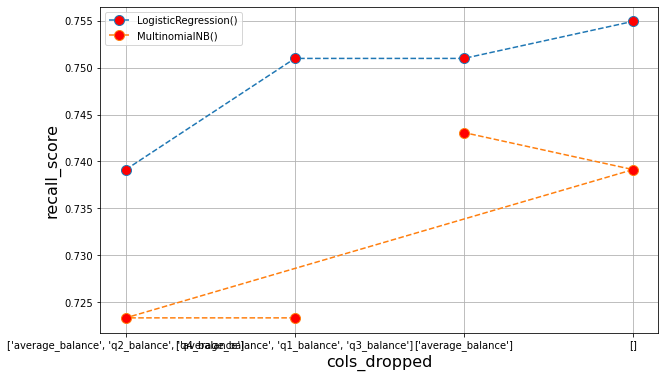

In [27]:
params = OrderedDict(
    models = [LogisticRegression(), MultinomialNB()],
    cols_dropped = multicoll_drop
)
metrics.report_metrics(params, recall_score, all_test, all_pred, label='Yes',
                        sort_by_metric=True, show_plot=True, hue='models')

#### 4. Outliers (threshold optimization)

In [29]:
# optimized parameters
# model
models = [MultinomialNB(), LogisticRegression()]
# encoder
encoder = OneHotEncoder()
# scaler
scaler = Normalizer()
# reduced dataset
df_reduced = df.drop(cols_to_drop_2, axis=1)


In [30]:
# optimize on threshold for dropping outliers
thresholds = [None, 1.5, 2, 2.5, 3, 3.5]
skip_cols = ['bank_accounts_open', 'homes_owned', 'household_size']
all_test, all_pred, all_reports = [], [], []
for model in models:
    for threshold in thresholds:
        print('Model: ', str(model).strip('()')) 
        print('Threshold for outliers: ',threshold)
        df_reduced = df.drop(cols_to_drop, axis=1) # multicoll dropping
        try:
            y_test, predictions, report = sktools.score_classification_model(
                                    df=df_multicoll,
                                    target=target,
                                    model=model,
                                    cols_to_encode=[cols_onehot_encod],
                                    scaler=scaler,
                                    encoders=[encoder],
                                    outsiders_thresh=threshold,
                                    skip_outsiders_cols=skip_cols,
                                    balance_dataset=True,
                                    balancer=SMOTE()
            )
            print(report, end='\n\n')
            all_test.append(y_test)
            all_pred.append(predictions)
            all_reports.append(report)
        except:
            print('****FAILED****', end='\n\n')
            all_test.append(np.nan)
            all_pred.append(np.nan)
            all_reports.append(np.nan)

Model:  MultinomialNB
Threshold for outliers:  None
              precision    recall  f1-score   support

          No       0.98      0.67      0.79      4241
         Yes       0.12      0.74      0.20       253

    accuracy                           0.67      4494
   macro avg       0.55      0.70      0.50      4494
weighted avg       0.93      0.67      0.76      4494


Model:  MultinomialNB
Threshold for outliers:  1.5
              precision    recall  f1-score   support

          No       0.98      0.64      0.78      4092
         Yes       0.12      0.76      0.21       271

    accuracy                           0.65      4363
   macro avg       0.55      0.70      0.49      4363
weighted avg       0.92      0.65      0.74      4363


Model:  MultinomialNB
Threshold for outliers:  2
              precision    recall  f1-score   support

          No       0.97      0.67      0.79      4092
         Yes       0.11      0.64      0.19       272

    accuracy                

,models,outliers_treshold,recall_score
0,MultinomialNB(),1.5,0.756458
1,LogisticRegression(),None,0.750988
2,MultinomialNB(),None,0.735178
3,LogisticRegression(),1.5,0.730627
4,MultinomialNB(),2.5,0.71374
5,LogisticRegression(),2.5,0.709924
6,LogisticRegression(),3,0.675182
7,LogisticRegression(),3.5,0.672662
8,MultinomialNB(),3,0.671533
9,MultinomialNB(),3.5,0.665468


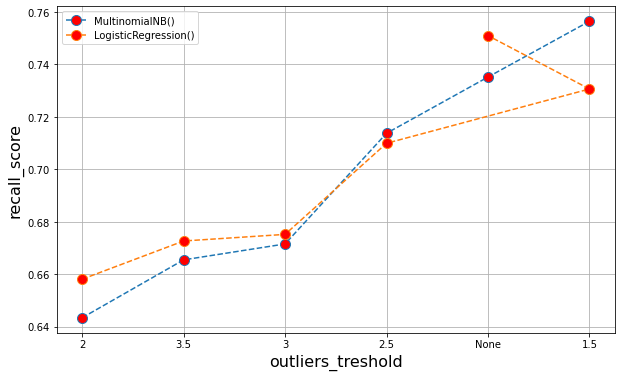

In [31]:
params = OrderedDict(
    models = [MultinomialNB(), LogisticRegression()],
    outliers_treshold = thresholds
)
metrics.report_metrics(params, recall_score, all_test, all_pred, label='Yes',
                        sort_by_metric=True, show_plot=True, hue='models')

Outliers should not be dropped

#### 5. Balancing Methods

In [32]:
# Optimised parameters until now
# accounted multicoll
cols_to_drop = ['average_balance', 'q1_balance', 'q3_balance']
# model
model = MultinomialNB()
# encoder
encoder = OneHotEncoder()
# scaler
scaler = Normalizer()
# reduced dataset
df_reduced = df.drop(cols_to_drop_2, axis=1)
# outliers
threshold = None

In [33]:
# optimize balancer
models = [MultinomialNB(), LogisticRegression()]
balancers = [SMOTE(), TomekLinks(), SMOTEENN(), SMOTETomek()]
all_test, all_pred, all_reports = [], [], []

for model in models:
    for balancer in balancers:
        print('Model: ', str(model).strip('()')) 
        print('Balancer: ', balancer)
        df_reduced = df.drop(cols_to_drop, axis=1) # multicoll dropping
        try:
            y_test, predictions, report = sktools.score_classification_model(
                                    df=df_multicoll,
                                    target=target,
                                    model=model,
                                    cols_to_encode=[cols_onehot_encod],
                                    scaler=scaler,
                                    encoders=[encoder],
                                    balance_dataset=True,
                                    balancer=balancer
            )
            print(report, end='\n\n')
            all_test.append(y_test)
            all_pred.append(predictions)
            all_reports.append(report)
        except:
            print('****FAILED****', end='\n\n')
            all_test.append(np.nan)
            all_pred.append(np.nan)
            all_reports.append(np.nan)

Model:  MultinomialNB
Balancer:  SMOTE()
              precision    recall  f1-score   support

          No       0.98      0.66      0.78      4241
         Yes       0.11      0.74      0.20       253

    accuracy                           0.66      4494
   macro avg       0.55      0.70      0.49      4494
weighted avg       0.93      0.66      0.75      4494


Model:  MultinomialNB
Balancer:  TomekLinks()
              precision    recall  f1-score   support

          No       0.94      1.00      0.97      4241
         Yes       0.00      0.00      0.00       253

    accuracy                           0.94      4494
   macro avg       0.47      0.50      0.49      4494
weighted avg       0.89      0.94      0.92      4494


Model:  MultinomialNB
Balancer:  SMOTEENN()
              precision    recall  f1-score   support

          No       0.98      0.60      0.74      4241
         Yes       0.11      0.81      0.19       253

    accuracy                           0.61      

,models,balancer,recall_score
0,MultinomialNB(),SMOTEENN(),0.810277
1,LogisticRegression(),SMOTEENN(),0.790514
2,MultinomialNB(),SMOTETomek(),0.743083
3,LogisticRegression(),SMOTE(),0.743083
4,LogisticRegression(),SMOTETomek(),0.743083
5,MultinomialNB(),SMOTE(),0.73913
6,MultinomialNB(),TomekLinks(),0.0
7,LogisticRegression(),TomekLinks(),0.0


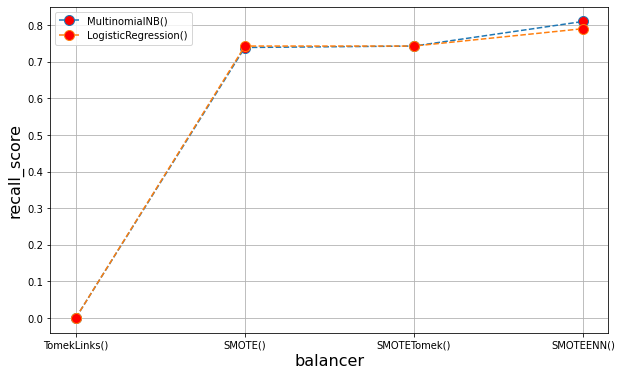

In [34]:
params = OrderedDict(
    models = [MultinomialNB(), LogisticRegression()],
    balancer = [SMOTE(), TomekLinks(), SMOTEENN(), SMOTETomek()]
)
metrics.report_metrics(params, recall_score, all_test, all_pred, label='Yes',
                        sort_by_metric=True, show_plot=True, hue='models')

SmoteEnn is my choice. It works similiarly on both models. <br>
Tough fight betweem Logistic Regression and Naive Bayes classifier

#### 6. Logistic Regression optimization

In [35]:
# Preparing the model
X_train, X_test, y_train, y_test = sktools.split_data(df_reduced,
                                                        target = config.TARGET,
                                                        test_size=0.3,
                                                        random_state=42)
sktools.scale_data(X_train, X_test, scaler_class=Normalizer())
X_train, X_test = sktools.encode_data(X_train, X_test, encoders=[OneHotEncoder()],
                                        cols_to_encode=[cols_onehot_encod])
balancer = SMOTEENN()
X_train, y_train = balancer.fit_resample(X_train, y_train)

In [36]:
# Try an optimization of Logistic Regression
# define parameters
C = np.logspace(-4, 4, 50)
penalty = ['l1', 'l2']
model=LogisticRegression()
grid = {'C': C, 'penalty': penalty}
clf = GridSearchCV(estimator=model,
                       param_grid=grid,
                       cv=5,
                       scoring='roc_auc')
clf.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': array([1.00000000e-04, 1.45634848e-04, 2.12095089e-04, 3.08884360e-04,
       4.49843267e-04, 6.55128557e-04, 9.54095476e-04, 1.38949549e-03,
       2.02358965e-03, 2.94705170e-03, 4.29193426e-03, 6.25055193e-03,
       9.10298178e-03, 1.32571137e-02, 1.93069773e-02, 2.81176870e-02,
       4.09491506e-02, 5.96362332e-02, 8.685113...
       3.72759372e+00, 5.42867544e+00, 7.90604321e+00, 1.15139540e+01,
       1.67683294e+01, 2.44205309e+01, 3.55648031e+01, 5.17947468e+01,
       7.54312006e+01, 1.09854114e+02, 1.59985872e+02, 2.32995181e+02,
       3.39322177e+02, 4.94171336e+02, 7.19685673e+02, 1.04811313e+03,
       1.52641797e+03, 2.22299648e+03, 3.23745754e+03, 4.71486636e+03,
       6.86648845e+03, 1.00000000e+04]),
                         'penalty': ['l1', 'l2']},
             scoring='roc_auc')

In [37]:
print('Best C =', clf.best_estimator_.get_params().get('C'))
print('Best penalty =', clf.best_estimator_.get_params().get('penalty'))
C_opt =  clf.best_estimator_.get_params().get('C')

Best C = 1048.1131341546852
Best penalty = l2


In [41]:
# Optimized Logistic Regression
y_test, predictions, report = sktools.score_classification_model(
                                    df=df_reduced,
                                    target=target,
                                    model=LogisticRegression(C=C_opt),
                                    cols_to_encode=[cols_onehot_encod],
                                    scaler=Normalizer(),
                                    encoders=[OneHotEncoder()],
                                    balance_dataset=True,
                                    balancer=SMOTEENN())
print(report)

              precision    recall  f1-score   support

          No       0.98      0.65      0.78      4241
         Yes       0.12      0.77      0.20       253

    accuracy                           0.66      4494
   macro avg       0.55      0.71      0.49      4494
weighted avg       0.93      0.66      0.75      4494



### 7. SVC optimization

In [39]:
# Preparing the model
X_train, X_test, y_train, y_test = sktools.split_data(df_reduced,
                                                        target = config.TARGET,
                                                        test_size=0.3,
                                                        random_state=42)
sktools.scale_data(X_train, X_test, scaler_class=Normalizer())
X_train, X_test = sktools.encode_data(X_train, X_test, encoders=[OneHotEncoder()],
                                        cols_to_encode=[cols_onehot_encod])
balancer = SMOTETomek()
X_train, y_train = balancer.fit_resample(X_train, y_train)

In [ ]:
# Try an optimization of SVC 
# define parameters
grid = {'C': [0.1,1, 10, 100], 
        'gamma': [1,0.1,0.01,0.001],
        'kernel': ['rbf', 'poly', 'sigmoid', 'linear']}

model=SVC()
clf = GridSearchCV(estimator=model,
                       param_grid=grid,
                       scoring='roc_auc',
                       verbose=2)
# clf.fit(X_train, y_train)  # this will take a long time

# save object with pickle for reusability

### Final Metrics of our model

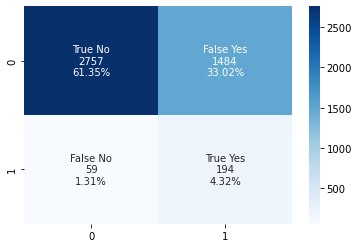

In [42]:
# Metrics of the chosen model
metrics.plot_confusion_matrix(y_test, predictions)

### Economic study

It seems we have found our model for our business problem. With the Logistic <br>
Regression algorithm we reach a recall up to 76-77%. In these business <br>
problems recall is one of the most important parameter beacuse is more useful to try to <br>
find (predict) all the 'Yes' for the card-offer acceptance. Precision is low (0.11-0.12) <br>
and that implies that we are going to predict a lot of 'Yes' that are actually 'No'. <br>
Now that we have maximised the recall, we should find a trade-off to maximize revenue.


Let’s suppose the management team now give us the following information:
 - The database contains 1 M of customers.
 - The cost of sending a mail/postcard is 5 $
 - The offer acceptance brings to the company 100$
 - Every true positive means we have encountered the potential customer and he/she will accept the offer <br> bringing to the company (+100$ - $)
 - Every true negative mean we have correctly not sent an email to a customer that would not accept <br> the offer (0$)
 - Every false negative means we have lost an opportunity with a potential customer (-100$)
 - Every false positive mean we sent an email to a customer that will not accept the offer (-5$)



An approach without ML model will bring to the company:

In [43]:
n_customers = 1e6 # $
customer_acceptance_gain = 100 # $
mail_cost = 5 # $
historic_customer_acceptance_rate = df[target].value_counts()['Yes'] / (df[target].value_counts()['Yes'] +
                                                                         df[target].value_counts()['No'])
# With no model, mail is sent to all the customer and will get the historic rate of customer acceptance
revenue =  - mail_cost*n_customers + historic_customer_acceptance_rate*n_customers*customer_acceptance_gain
print('Stupid model')
print('Revenue: ', round(revenue, 2), '$')

Stupid model
Revenue:  679795.28 $


In [44]:
def calculate_revenue(y_test, predictions, n_customers, customer_acceptance_gain, email_cost):
    """Calculate revenue"""
    if pd.Series(y_test).unique().dtype in [int, 'int32', 'int64']:
        y_test = pd.Series(y_test).replace({0: 'No', 1: 'Yes'})
    if pd.Series(predictions).unique().dtype in [int, 'int32', 'int64']:
        predictions = pd.Series(predictions).replace({0: 'No', 1: 'Yes'})
    
    confusion = confusion_matrix(y_test, predictions)
    TP = confusion[1, 1]*n_customers/(len(y_test)) # True positive
    FP = confusion[0, 1]*n_customers/(len(y_test)) # False positive
    FN = confusion[1, 0]*n_customers/(len(y_test)) # False negative
    revenue = - email_cost*(TP+FP) - customer_acceptance_gain*(FN) + customer_acceptance_gain*(TP)
    return revenue

In [46]:
# Revenue with the mathemaically optimised model
print('Benchmark optimized model:')
print(
    calculate_revenue(y_test, predictions, n_customers,
                         customer_acceptance_gain, mail_cost)
)

Benchmark optimized model:
1137071.6510903435


Optimized threshold for Logistic Regression

In [47]:
# Apply Logistic Regression with optimised parameters and optimised threshold
# Preparing the model
X_train, X_test, y_train, y_test = sktools.split_data(df_reduced,
                                                        target = config.TARGET,
                                                        test_size=0.3,
                                                        random_state=42)
sktools.scale_data(X_train, X_test, scaler_class=Normalizer())
X_train, X_test = sktools.encode_data(X_train, X_test, encoders=[OneHotEncoder()],
                                        cols_to_encode=[cols_onehot_encod])
balancer = SMOTEENN()
X_train, y_train = balancer.fit_resample(X_train, y_train)

tpr-fpr optimised model
1424068.2366030035
              precision    recall  f1-score   support

          No       0.98      0.62      0.76      5079
         Yes       0.11      0.80      0.20       314

    accuracy                           0.63      5393
   macro avg       0.55      0.71      0.48      5393
weighted avg       0.93      0.63      0.73      5393



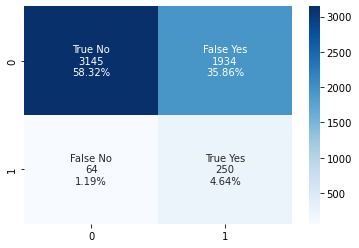

In [50]:
# Find best model for best TPR - FPR
model = LogisticRegressionWithThreshold()
model.fit(X_train, y_train)

# Find optimal threshold and predict with it
threshold, optimal_tpr_minus_fpr = \
    model.threshold_from_optimal_tpr_minus_fpr(X_train, y_train)
y_pred = model.predict(X_test, threshold)

metrics.plot_confusion_matrix(y_test, 
                                pd.Series(y_pred).replace({0: 'No', 1: 'Yes'}))

print('tpr-fpr optimised model')
print(
    calculate_revenue(y_test, y_pred, n_customers, \
                            customer_acceptance_gain, mail_cost)
)
print(classification_report(y_test, \
    pd.Series(y_pred).replace({0: 'No', 1: 'Yes'})))

In [52]:
# Apply model optimized in tpr-fpr
model = LogisticRegressionWithThreshold()
model.fit(X_train, y_train)

threshold, max_cost, df_cost = model.threshold_from_cost_function(X_train, y_train,
                                                                 calculate_revenue,
                                                                 n_customers,
                                                                 customer_acceptance_gain,
                                                                 mail_cost
                                                            )
y_pred = model.predict(X_test, threshold)

print(threshold, max_cost)
metrics.plot_confusion_matrix(y_test, pd.Series(y_pred).replace({0: 'No', 1: 'Yes'}))

print('Revenue optimized model')
print(
    calculate_revenue(y_test, y_pred, n_customers, 
                    customer_acceptance_gain, mail_cost)
)
print(classification_report(y_test, 
               pd.Series(y_pred).replace({0: 'No', 1: 'Yes'})))

  1%|▏         | 192/14730 [00:16<20:39, 11.73it/s]


KeyboardInterrupt: 